### Проверка гипотезы о возможности классификации набора данных по наличию угрозы безопастности системы  

#### Цель задачи:
    Система выполняет автоматический мониторинг ситуаций, представляющих потенциальную угрозу сетевой безопасности.  
	При обнаружении действий, котрые потенциально могут представлять угрозу сетевой безопасности, Система автоматически регистрирует в JIRA задачу для исследования ситуации.   

	Количество регистрируемых задач в единицу времени очень велико, но не все из них описывают реальную угрозу.  
	Для сокращения времени реакции специалистов и увеличения скорости выявления реальных угроз безопасности  
	необходимо реализовать механизм отделение реальных угроз безопасности от мнимых.  
#### Тип решаемой задачи: 
- Бинарная классификация
#### Единичный объект в выборке: 
- запись в Jira о задаче на исследование зарегистрированной угрозы безопастности
#### Цель прогноза: 
- Предсказать является ли угроза описанная в задаче Реальной или Мнимой
- Значения целевой метки классов:  
	label = 1 , если угроза Реальная  
	label = 0 , если угроза Мнимая
#### Принцип формирования выборок трейн/валидация/тест:
- Stratified k-Fold (из 5-ти foldов)
#### Метрики качества:
- Полнота предсказания класса label=1  
		Recall (TP/(TP + FN))
- Точность предсказания класса label=1   
		Precision (TP/(TP+FP))
### Желаемые значения метрик: 
- Recal ~ 1 (100%)  
		Не должно быть записей класса 1 (Реальные угрозы) ложно классифицированных как 0 (Мнимые угрозы)
- Precision > 0,3   
		Количество верно предсказанных записей класса 1 не меньше 30% от всех полученных записей данного класса
#### Алгоритмы для проверки гипотезы: 	
- Logistic Regression
- Random Forest
- XGBoost
#### Примечание:
Обязательно рассмотреть различные методы Feature selection, Feature engineering и Оutlier detection  
Выполнить подбор гиперпараметров моделей

#### Обоснование желаемых значений метрик:

Нам требуется получить метрику Recall (Полнота предсказания класса label=1) равную 1, т.е. чтобы не было реальных угроз, ложно классифицированных как мнимые.

Обоснуем выбор требуемого значения метрики Precision (Точность предсказания класса label=1)

In [ ]:
import numpy as np
from sklearn.metrics import precision_score, recall_score

In [ ]:
# Возьмём ряд чисел размерностью 6500, где примерно 30% - это 1 (Реальные угрозы), остальные 70% - это 0 (Мнимые угрозы)
# ( т.е. примерно такоя же распределение классов, которое наблюдается в исходном наборе данных )
y_true = np.random.choice([0, 1], size = 6500, p = [.7, .3])
# Подготовим прогнозы нашей модели
# ( представим, что это наивная модель, которая выдаёт всегда только класс 1 )
y_pred = np.ones(y_true.shape)

In [ ]:
# Измерим метрику Recall для класса 1 
print('Recall: {}'.format(recall_score(y_true, y_pred, pos_label = 1)))
# Видим, что значение метрики = 1. 
# Это логично, ведь все прогнозы у нас заполнены единицами, чтобы мы точно не пропустили реальную угрозу

In [ ]:
# Измерим метрику precision для класса 1. 
print('Precision: {}'.format(precision_score(y_true, y_pred, pos_label = 1)))
# Видим, что он равен ~ 0.3, т.е. это доля реальных угроз в исходных данных

In [ ]:
# Теперь предположим, что хотя бы 100 мнимых угроз нам удалось выявить 
# (т.е. 0 мы классифицировали как 0, притом что recall = 1):
indices = np.where((y_true == 0) & (y_pred == 1))[0]
random_indices = np.random.choice(indices, size = 100, replace = False)
y_pred[random_indices] = 0

print('Precision: {}'.format(precision_score(y_true, y_pred, pos_label = 1)))
# Видно, что метрика Precision улучшилась !!!

Вывод:  
    за цель мы берём следующие значения метрик:  
- Recall = 1, 
- Precision > 0.3

#### Подключение библиотек

In [1]:
import re
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import association_metrics as am

from pymorphy2 import MorphAnalyzer

from sklearn import metrics
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split, cross_validate
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import RandomForestClassifier, IsolationForest

import xgboost
from xgboost import XGBClassifier

import warnings
warnings.simplefilter('ignore')

%matplotlib inline
from matplotlib import pyplot as plt

DATA_FILE = 'Domain_1_2_processed_fixed.xlsx'
RANDOM_STATE = 42

#### Чтение данных из файла
- отбор нужных столбцов и преобразование структуры таблицы в форму удобную для анализа
- предварительных анализ признаков

In [2]:
df = pd.read_excel(io=DATA_FILE, engine='openpyxl')

col_dict = {
    'Решение по заявке':'label',  
    'Приоритет':        'priority',
    'Название':         'title',
    'UseCase':          'use_case',
    'Dest Host':        'dst_host',
    'Source Host':      'src_host',
    'Dest Network':     'dst_net',
    'Source Network':   'src_net',
    'Один хост':        'one_host',
    'Одна сеть':        'one_net',
    'Dest IP':          'dst_ip',
    'Source IP':        'src_ip',
    'Имя пользователя': 'user',
    'Add_info':         'add_info',
    'Решение':          'solution',
}

df.columns = [col_dict.get(x,x) for x in df.columns]

src_cols = ['label','priority','title','use_case','src_host','dst_host','src_net','dst_net','one_host','one_net','dst_ip','src_ip','user','add_info','solution']

df = df[src_cols]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20109 entries, 0 to 20108
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   label     20109 non-null  object
 1   priority  20109 non-null  object
 2   title     20109 non-null  object
 3   use_case  20109 non-null  object
 4   src_host  20109 non-null  object
 5   dst_host  20109 non-null  object
 6   src_net   20109 non-null  object
 7   dst_net   20109 non-null  object
 8   one_host  20109 non-null  int64 
 9   one_net   20109 non-null  int64 
 10  dst_ip    20109 non-null  object
 11  src_ip    20109 non-null  object
 12  user      19867 non-null  object
 13  add_info  20109 non-null  object
 14  solution  20103 non-null  object
dtypes: int64(2), object(13)
memory usage: 2.3+ MB


Посморим на количество уникальных значений для каждого признака

In [3]:
df.nunique()

label           8
priority        4
title         245
use_case       38
src_host     1801
dst_host      461
src_net        45
dst_net        26
one_host        3
one_net         3
dst_ip       1897
src_ip       2677
user         1653
add_info    10366
solution     2145
dtype: int64

- признаки `solution` и `add_info` добавлены для анализа признаков и не будет использоваться в обучении
- все остальные признаки рассматриваются как категориальные и будут преобразованы в числовую форму

Проверим признаки на наличие пустых значений (NULL)

In [4]:
df.isna().sum()

label         0
priority      0
title         0
use_case      0
src_host      0
dst_host      0
src_net       0
dst_net       0
one_host      0
one_net       0
dst_ip        0
src_ip        0
user        242
add_info      0
solution      6
dtype: int64

- Записи с пустыми признаками `solution` оставляем, т.к. данные признаки не будут использоваться в обучении
- Записи с пустыми значениями `user` будут учтены при преобразовании признака в числовую форму

In [5]:
# Удаляем записи для которых значение признаков = NULL,  
# если их количество не велико и у нас нет адекватных критериев для восстановления их значений 
# df.dropna(axis = 0, subset = ['признак1','признак2'], inplace = True)

#### Feature selection

##### Кодирование признака `label`  
выполняем таким образом, чтобы `label`=1 был классом меньшинства ("Реальные" угрозы) - т.к. для этого класса мы будем оценивать желаемые метрики `Recall` и `Precision`  

Будут назначены следующие значения:
- `-1` - для решений 'None' и 'Связанный инцидент'
- `0` - для решений 'False Positive'
- `1` - для всех прочих решения

In [6]:
df.label = df.label.replace({
    'None': -1, 
    'Связанный инцидент': -1,
    'Context False Positive': 0,
    'Request False Positive': 0,
    'Предоставлено решение': 1, 
    'Автоматически закрыт': 1, 
    'Не будет выполнено': 1,
    'CRE Misconfig': 1,
    'Готово': 1,
})

# Проверить распределение меток по категориям
df.label.value_counts()

-1    13562
 0     4469
 1     2078
Name: label, dtype: int64

Количество записей которые нельзя однозначно классифицировать как 'Реальную' или 'Мнимую' угрозу = 13562, что составляет > 60% записей набора данных!    

По полученной информации, значений признака `label` (Решение по заявке) назначается на основании значения поля `solution` (Решение).  
Таки образом можно попробовать повторно классифицировать значения целевых меток с неоднозначной категорией `-1` следующим образом:
- определить множество S значений поля `solution` для записей с `label` = 1
- назначить `label` = 1 для всех записей с `label` = -1, в которых значения `solution` относятся к множеству S

Но предварительно проверим, что множества значений поля `solution` для записей с классами `1` и `0` не пересекаются:

In [7]:
# Множество значений solution для записей содержащих "реальные" угрозы (label = 1)
real_threat_solutions = set(df[df.label == 1].solution)
# Множество значений solution для записей содержащих "мнимые" угрозы (label = 0)
fake_threat_solutions = set(df[df.label == 0].solution)
# Пересечение значений solution для мнимых и реальных угроз 
intersec_set = real_threat_solutions.intersection(fake_threat_solutions)
print(intersec_set)

{'вредоносной активности не обнаружено', 'объекты удалены', 'поступление событий восстановлено.', 'события поступают', 'вредоносной активности нет.', 'заказчик подтвердил легитимность.', '-', 'события поступают в штатном режиме.', 'решение еще не найдено.', 'события поступают в штатном режиме', 'объекты удалены средствами авпо', 'события поступают.', 'вредоносные объекты заблокированы средствами авпо.', 'переданный файл iz:soc для заказчика. ', 'заказчик подтвердил легитимность', ' 87bde24aaf69cb1cf15a88871a1ade69cfb5b0ce605503cff3f9eea103591d56 - принадлежит сети vpn, по согласованию с заказчиком подобная dns активность, инициатором которой является пользователь vpn, не входит в мониторинг iz:soc  ', 'вредоносной активности не обнаружено ', 'активность вызвана недавней сменой пароля'}


Проверка провалилась!  
Визуально видно, что множества значений `solution` для классов `0` и `1` пересекаются как раз на основных значениях которые, якобы, дожны характеризовать "Мнимые" угрозы!  

Отбразим распределение записей набора данных по классам `label`, у которых значения `solution` относятся к полученному пересечечнию множеств:

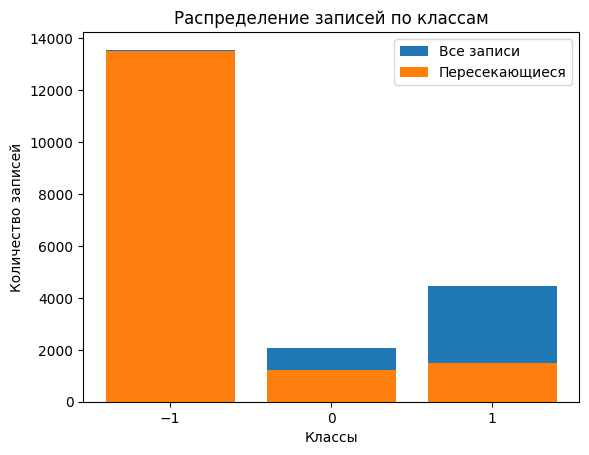

In [8]:
# Фильтр индексов записей для которых значения solution лежат на пересечении Real и Fake множеств
filter = df.solution.isin(intersec_set)

labels_original = df.label.value_counts()
labels_filtered = df.loc[filter].label.value_counts()

plt.bar([-1,1,0],labels_original, label='Все записи') 
plt.bar([-1,1,0],labels_filtered, label='Пересекающиеся') 
plt.title("Распределение записей по классам")
plt.ylabel("Количество записей")
plt.xlabel("Классы")
plt.xticks([-1,1,0])
plt.legend()
plt.show()

Видим, что записи относящиеся к различным классам `label` имеют существенное количество одинаковых значений признака `solution`!!!  
Таким образом, т.к. мы не можем однозначно классифициовать записи с признаком `label` = -1, то удаляем их из набора данных.

In [9]:
df.drop(df[df.label == -1].index, inplace=True)
df.shape

(6547, 15)

Далее создадим отдельный dataframe для кодирования и анализа признаков

In [10]:
df_features = df.iloc[:,:-1].copy() # Признак `solution` не включаем в набор 

##### Кодирование признаков `src_ip`, `dst_ip`, `src_host`, `dst_host`, `src_net`, `dst_net` и `user`.
Данные признаки содержат, в общем случае, перечисления через запятую соответствующих значений.  
Так как конечное множество значений для данных признаков не определено, выполним кодирование следующим образом:
- `0` - если конкретное значение IP/Host/Network не определено или не задано;
- `1` - задано одно значение IP/Host/Network;
- `2` - задано перечисление IP/Host/Network.

In [11]:
MAXSPLIT = 1 # количество категорий (для заданного MAXSPLIT формируются категории - 0,1, .... до MAXSPLIT+1)

# Функция категоризации значений признаков
def categorize(val):
    x = str(val).strip().lower()
    if x=='-' or x=='--' or x=='none' \
        or x=='hostname не определен' or x=='not available' \
        or x=='Сеть не определена' \
        or x=='' or x.isspace(): 
        return 0   
    elif x=='multiple':
        return MAXSPLIT+1 
    else:
        try:
            n = len(x.split(',', MAXSPLIT))
        except Exception:
            print(f'WTF....{x}?')
            n = -1
        return n

# Кодирование признаков 
df_features.user = df_features.user.transform(categorize)

df_features.src_ip = df_features.src_ip.transform(categorize)
df_features.dst_ip = df_features.dst_ip.transform(categorize)

df_features.src_host = df_features.src_host.transform(categorize)
df_features.dst_host = df_features.dst_host.transform(categorize)

df_features.src_net = df_features.src_net.transform(categorize)
df_features.dst_net = df_features.dst_net.transform(categorize)

##### Кодирование признаков `title`, `use_case`, `priority`, `one_host` и `one_net`.
Так как данные признаки имеют значения из конечного множества допустимых значений,  
для их кодирования в численное представление воспользуемся методом Label Encoding – сопоставим каждому значению целое положительное число начиная с нуля (0).

In [12]:
enc = OrdinalEncoder()

# Кодирование признаков целыми положительными значениями
df_features.one_net = df_features.one_net + 1
df_features.one_host = df_features.one_host + 1
df_features.title = enc.fit_transform(df_features[['title']])
df_features.use_case = enc.fit_transform(df_features[['use_case']])
df_features.priority = enc.fit_transform(df_features[['priority']])

##### Анализ важности признаков по критериям `Chi-square` (Chi2) и `Information Gain` (IG) 
Выполним расчет критерием важности для всех признаков кроме `add_info` относительно целевой метки класса  
(признак `add_info` преобразован в векторную форму и анализировать его вместе с остальными признаками будет затруднительно)


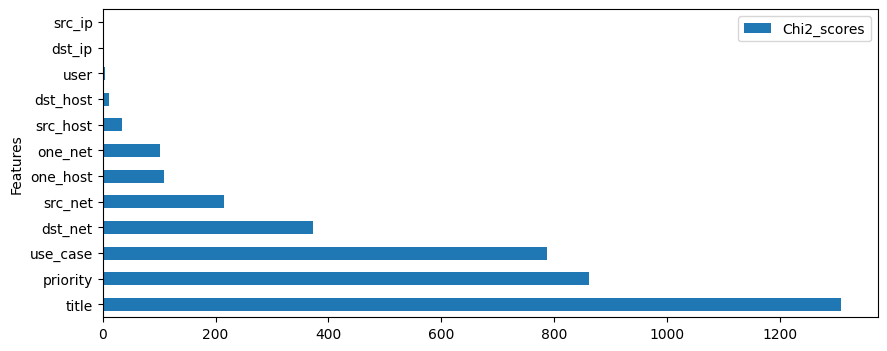

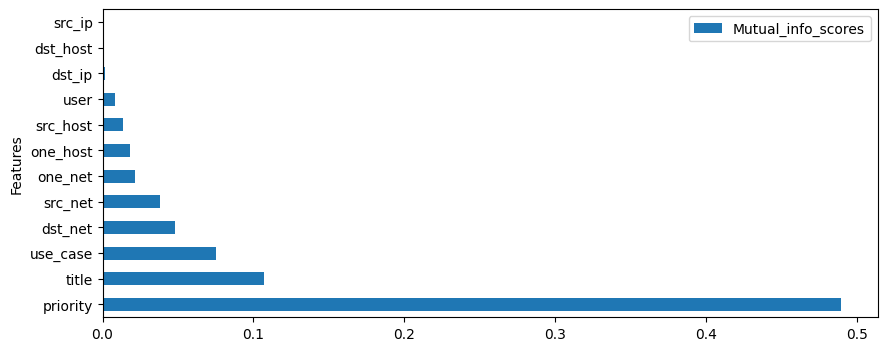

In [13]:
# Приведем все признаки к категориальному типу
df_features = df_features.astype('category')

# Выделим набор целевых меток классов
target = df_features.label

# Критерий Хи-квадрат (Chi-square Test)
# Вычисляется значение Хи-квадрат между каждым признаком и целью - чем больше значение, тем сильнее связь между ними
chi2_features = SelectKBest(score_func=chi2, k='all')
chi2_scores = chi2_features.fit(df_features.iloc[:,1:-1], target) # исключим из набора признаки label и add_info

# Сбор информации (Information Gain, IG)
# Вычисляется уменьшение энтропии в результате преобразования набора данных. 
# Используется для оценки информационного прироста каждого признака в контексте целевого признака.
mut_info_features = SelectKBest(score_func=mutual_info_classif, k='all')
mut_info_scores = mut_info_features.fit(df_features.iloc[:,1:-1], target) # # исключим из набора признаки label и add_info

# Сформируем выходные данные
df_result = pd.DataFrame({
    'Features': pd.Series(df_features.iloc[:,1:-1].columns), 
    'Chi2_scores': pd.Series(chi2_scores.scores_),
    'Mutual_info_scores': pd.Series(mut_info_scores.scores_)})

#print(df_result.nlargest(df_features.shape[1],'Chi2_scores'))
df_result.nlargest(df_features.shape[1],'Chi2_scores').plot(x='Features', y='Chi2_scores', kind='barh', figsize=(10,4))
df_result.nlargest(df_features.shape[1],'Mutual_info_scores').plot(x='Features', y='Mutual_info_scores', kind='barh', figsize=(10,4))
plt.show()

##### Анализ коэффициента корреляции признаков

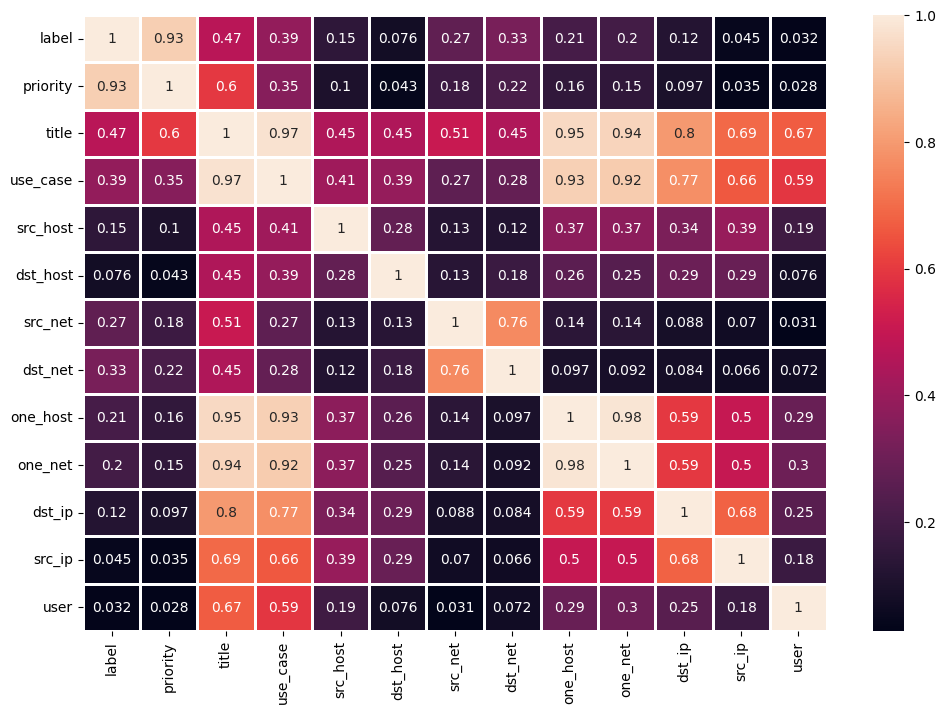

In [14]:
# Корреляция – мера линейной связи двух или более переменных, более важные переменные сильнее коррелируют с целевой меткой.
# Для категориальных переменных корреляция рассчитывается по методу Крамера (Cramer's V)

# Initialize a CramersV object using the pandas.DataFrame (df)
cramers_v = am.CramersV(df_features.iloc[:,:-1])
# Pairwise matrix filled with Cramer's V, where columns and index are the categorical variables of the passed pandas.DataFrame
df_corr_crsV = cramers_v.fit().round(3)

plt.figure(figsize=(12, 8))
sns.heatmap(df_corr_crsV, annot=True, linewidths=1)
plt.show()

##### Выводы по анализу важности признаков:  
1. признаки `src_ip`, `dst_host` и `user` получают минимальную оценку совокупно по критериям `Chi2` и `IG`,  
     так же, данные признаки имеют минимальную кореляцию с целевой меткой класса (меньше 0.08).  
     Учитывая, что при этом, признаки `src_ip` и `user` имеет высокую корреляцию с признаками `title` и `use_case`, то данные признаки можно удалить из набора данных без потери информации;  
    
2. признак `priority` получает максимальную оценку совокупно по критериям `Chi2` и `IG`,  
    и при этом, данный признак имеет очень высокую корреляцию с целевой меткой класса (+0.93)!    
    Фактически, такая корреляция с целевой меткой означает, что все остальные признаки кроме `priority` просто не будут использоваться моделями при обучении!!!

##### Проверка предположений о важности признаков

In [15]:
# Подготовка данных для обучения
y = df_features.label
X = df_features.iloc[:,1:-1] # Копируем признаки кроме label и add_info

# Преобразовать категориальные признаки в разреженную форму
X = X.astype('category')
X = pd.get_dummies(X, columns=X.columns)

X.head(5)

,priority_0.0,priority_1.0,priority_2.0,title_0.0,title_1.0,title_2.0,title_3.0,title_4.0,title_5.0,title_6.0,...,one_net_2,dst_ip_0,dst_ip_1,dst_ip_2,src_ip_0,src_ip_1,src_ip_2,user_0,user_1,user_2
3,0,1,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,1,0,0
4,0,1,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,1,0,0
5,0,1,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,1,0,0
6,0,1,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,1,0,0
7,0,1,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,1,0,0


В качестве базовой модели для проверки используем модель Логистической регрессии с параметрами по умолчанию

In [16]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

df_results = pd.DataFrame({'Metrics': pd.Series(['Precision','Recall','F1'])})

# Перекрестная проверка на полном наборе признаков
scores = cross_validate(
    LogisticRegression(class_weight='balanced', n_jobs=-1, random_state=RANDOM_STATE), 
    X, y, scoring=['f1','recall','precision'], cv=skf, n_jobs=-1)
df_results['All_feats'] = pd.Series([scores['test_precision'].mean(), scores['test_recall'].mean(), scores['test_f1'].mean()])

# Перекрестная проверка модели на наборе содержащем только признак Priority
scores = cross_validate(
    LogisticRegression(class_weight='balanced', n_jobs=-1, random_state=RANDOM_STATE),
    X.iloc[:,0:3], y, scoring=['f1','recall','precision'], cv=skf, n_jobs=-1)
df_results['Only_priority'] = pd.Series([scores['test_precision'].mean(), scores['test_recall'].mean(), scores['test_f1'].mean()])

# Перекрестная проверка модели на наборе, из которого исключен признак Priority
scores = cross_validate(
    LogisticRegression(class_weight='balanced', n_jobs=-1, random_state=RANDOM_STATE),
    X.iloc[:,3:], y, scoring=['f1','recall','precision'], cv=skf, n_jobs=-1)
df_results['Except_priority'] = pd.Series([scores['test_precision'].mean(), scores['test_recall'].mean(), scores['test_f1'].mean()])

# Перекрестная проверка модели на наборе, из которого исключены признаки Priority и User  
scores = cross_validate(
    LogisticRegression(class_weight='balanced', n_jobs=-1, random_state=RANDOM_STATE),
    X.iloc[:,3:-3], y, scoring=['f1','recall','precision'], cv=skf, n_jobs=-1)
df_results['Except_priority-user'] = pd.Series([scores['test_precision'].mean(), scores['test_recall'].mean(), scores['test_f1'].mean()])

# Перекрестная проверка модели на наборе, из которого исключены признаки Priority, User и Src_ip,  
scores = cross_validate(
    LogisticRegression(class_weight='balanced', n_jobs=-1, random_state=RANDOM_STATE),
    X.iloc[:,3:-6], y, scoring=['f1','recall','precision'], cv=skf, n_jobs=-1)
df_results['Except_priority-user-src_ip'] = pd.Series([scores['test_precision'].mean(), scores['test_recall'].mean(), scores['test_f1'].mean()])

df_results

,Metrics,All_feats,Only_priority,Except_priority,Except_priority-user,Except_priority-user-src_ip
0,Precision,0.963532,0.998932,0.542107,0.541749,0.540824
1,Recall,0.933591,0.898942,0.766593,0.766110,0.763704
2,F1,0.948224,0.946247,0.634966,0.634553,0.633064


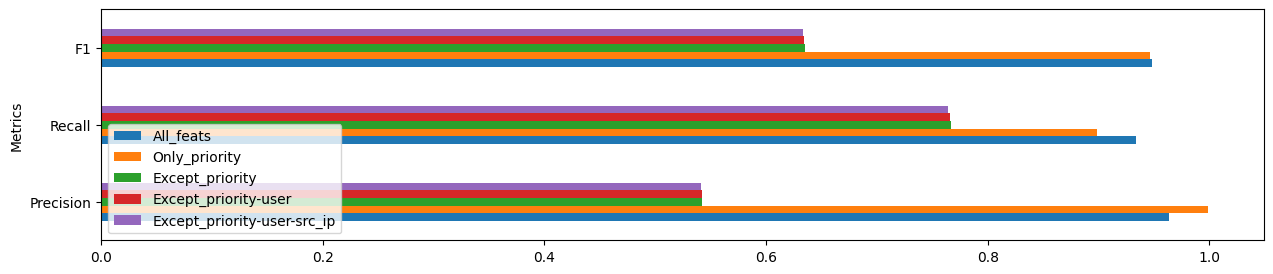

In [17]:
df_results.plot(x='Metrics', kind='barh', figsize=(15,3))
plt.legend(loc='lower left')
plt.show()

##### Выводы по результатам проверки:
1. При наличии в обучающем наборе признака `priority` метрики модели превышают 90%. 
    При этом, даже при обучении только на одном признаке `priority`, метрики практически не ухудшаются!
2. Если из набора исключить признак `priority` то метрики существенно ухудшаются (F1 = 63%), но все еще показывают результат близкий к ожидаемым значениям метрик.
3. Исключение из набора признаков `src_ip` и `user` не существенно снижает значения метрик.

Таким образом, 
- для чистоты дальнейших экспериментов признак `priority` исключаем из обучения.
- признаки `src_ip` и `dst_ip` в данном представлении не оказывают существенного влияния на результат и могут быть оставлены либо преобразованы.

In [18]:
df_results.drop(['Except_priority-user','Except_priority-user-src_ip'], axis=1, inplace=True)

#### Outlier detection
Выполним анализ набора данных на предмет выявления аномальных значений ("выбросов")

In [19]:
df_outlier = df_features.iloc[:,:-1]
# Для категориальных признаков применим алгоритмы IsolationForest и LocalOutlierFactor 
# Параметр contamination определяет долю выбросов в наборе данных, для определения порогового значения баллов зададим contamination = 0.1 (10%)
model_IF = IsolationForest(contamination=float(0.1),random_state=RANDOM_STATE)
model_LOF = LocalOutlierFactor(contamination=float(0.1), n_neighbors=5, novelty=False)

IF_pred = model_IF.fit_predict(df_outlier)
LOF_pred = model_LOF.fit_predict(df_outlier)

df_outlier['IF_pred'] = IF_pred
df_outlier['LOF_pred'] = LOF_pred

print('Оценка выбросов по IF \n{}'.format(df_outlier.IF_pred.value_counts()))
print('\nОценка выбросов по LOF \n{}'.format(df_outlier.LOF_pred.value_counts()))

Оценка выбросов по IF 
 1    5892
-1     655
Name: IF_pred, dtype: int64

Оценка выбросов по LOF 
 1    5913
-1     634
Name: LOF_pred, dtype: int64


Поверим сколько записей было отобрано как "выбросы" обоими алгоритмами

In [20]:
df_outlier.loc[((df_outlier.IF_pred == -1) & (df_outlier.LOF_pred == -1))]

,label,priority,title,use_case,src_host,dst_host,src_net,dst_net,one_host,one_net,dst_ip,src_ip,user,IF_pred,LOF_pred
101,0,1.0,199.0,23.0,1,0,0,0,0,0,0,0,0,-1,-1
354,0,1.0,199.0,23.0,1,0,0,0,0,0,0,0,0,-1,-1
558,1,2.0,14.0,10.0,1,0,1,0,2,2,1,1,2,-1,-1
864,1,2.0,96.0,6.0,0,0,0,0,0,0,2,1,0,-1,-1
1175,1,1.0,199.0,23.0,0,0,1,0,0,0,0,0,0,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14979,0,1.0,26.0,11.0,0,1,0,1,1,1,2,1,0,-1,-1
15056,1,2.0,96.0,6.0,0,1,1,1,0,0,1,1,0,-1,-1
15303,0,1.0,26.0,11.0,0,1,0,1,1,1,2,1,0,-1,-1
15641,1,2.0,96.0,6.0,0,0,0,0,0,0,2,1,0,-1,-1


Удалим записи которые были классифицированы как "выбросы" обоими алгоритмами.  
И проверим как изменятся метрики базовой модели.

In [21]:
# Получим индексы выбросов для удаления из набора данных
outlier_indexes = df_outlier[((df_outlier.IF_pred == -1) & (df_outlier.LOF_pred == -1))].index

# Удалим выбросы из набора
df_outlier = df_outlier.drop(outlier_indexes)

# Подготовим данные для обучения
y = df_outlier.label
X = df_outlier.iloc[:,2:-2] # копируем признаки кроме label, priority (1 и 2) и служебных IF_pred и LOF_pred (последние) 

# Преобразовать категориальные признаки в разреженную форму
X = X.astype('category')
X = pd.get_dummies(X, columns=X.columns)

In [22]:
scores = cross_validate(
    LogisticRegression(class_weight='balanced', n_jobs=-1, random_state=RANDOM_STATE),
    X, y, scoring=['f1','recall','precision'], cv=skf, n_jobs=-1)

# Средние значения метрик перекрестной проверки
df_results['W/O-Outliers'] = pd.Series([scores['test_precision'].mean(), scores['test_recall'].mean(), scores['test_f1'].mean()])
df_results

,Metrics,All_feats,Only_priority,Except_priority,W/O-Outliers
0,Precision,0.963532,0.998932,0.542107,0.539833
1,Recall,0.933591,0.898942,0.766593,0.765650
2,F1,0.948224,0.946247,0.634966,0.633183


Вывод:
- При удалении записей, классифицированных как `выбросы` метрики модели ухудшились по сравнению с набором данных без признаков `priority` и `add_info`

In [23]:
df_results.drop(['W/O-Outliers'], axis=1, inplace=True)

#### Feature engineering

1. В рассматриваемом наборе данных, значения большей части признаков (`src_ip`, `dst_ip`, `src_host`, `dst_host`, `src_net`, `dst_net`) потеряли значительную часть информации в следствии их перекодировки (значения заменялись на hash) из-за требований NDA, так и в следствии некорректной работы этого самого скрипта перекодировки.  
В их исходном состоянии существуют потенциальные возможности по формированию доп. признаков на базе работы со структурами IP-адресов (состоят из октетов XXX.XXX.XXX.XXX), и структурами DNS-имен хостов и сетей (различые уровни dns-имени).  
Но в существующем представлении эта информация нам не доступна.

2. Рссмотрим варианты формирования доп. признаков из имеющихся текстовых, методом векторизации по алгоритму TF-IDF 

##### Кодирование признака `add_info` дополнительной информации.
Так как данный признак содержит фрагменты лог-файлов и не поддается структуризации,  
то для его кодирования можно воспользоваться векторизацией признака по алгоритму TF-IDF.

In [24]:
from nltk.corpus import stopwords
stopwords = stopwords.words("russian")

morph = MorphAnalyzer()
TOKEN_PATTERN = r'\b[a-zа-яё0-9_@]{2,}\b' # любое слово от 2-х букв

# Векторизатор значений признака (с исключением стоп-слов)
feature_extractor = TfidfVectorizer(stop_words=stopwords, token_pattern=TOKEN_PATTERN)

# Функция токенизации и лемматизации тестовой строки
def tokenize(text: str): 
    word_set = set()
    for word in re.findall(TOKEN_PATTERN, text.lower()):
        word_set.add(morph.parse(word)[0].normal_form)
    return ' '.join(word_set)

# Токенизация и лематизация значений признака title
add_info = df_features.add_info.transform(tokenize)
add_info_vec = feature_extractor.fit_transform(add_info.values)
add_info_vec.shape

(6547, 15091)

Выделено очень большое количество признаков! Необходимо выполнить снижение размерности.  
Проанализируем признаки по важности относительно метки класса `label` используя критерий Хи-квадрат (Chi2)  
и отберем только признаки, для которых значение критерия больше заданного

In [46]:
target = df_features.label

# Критерий хи-квадрат (Chi-square Test) между признаком и целью - чем больше значение, тем сильнее связь между ними
chi2_features = SelectKBest(score_func=chi2, k='all')
chi2_scores = chi2_features.fit(add_info_vec, target)

# Формирование выходных данных
df_res = pd.DataFrame({
    'Features': pd.Series(range(add_info_vec.shape[1])), 
    'Chi2_scores': pd.Series(chi2_scores.scores_),})

print('Рейтинг признаков по критерию важности Хи-квадрат:')
print(df_res.nlargest(add_info_vec.shape[1],'Chi2_scores'))

df_best_res = df_res.nlargest(add_info_vec.shape[1],'Chi2_scores').loc[df_res.Chi2_scores > 1.5]

print('Количество признаков с критерием Хи2 > 1.5: {}'.format(df_best_res.__len__()))

Рейтинг признаков по критерию важности Хи-квадрат:
       Features   Chi2_scores
13982     13982  4.931144e+01
11782     11782  4.484060e+01
13983     13983  3.594923e+01
3481       3481  3.594923e+01
6774       6774  3.593490e+01
...         ...           ...
9041       9041  4.988110e-05
6495       6495  4.988110e-05
14918     14918  2.911035e-05
10500     10500  1.226763e-06
8303       8303  3.687717e-07

[15091 rows x 2 columns]
Количество признаков с критерием Хи2 > 1.5: 717


Экспериментальным путем выявлено, что лучшие значения метрик получаются для признаков с критерием Chi2 > 2

Сформируем отдельный набор данных из векторов признака `add_info`

In [47]:
df_add_info = pd.DataFrame(add_info)
for i in df_best_res.Features:
    col_name = 'title_{}'.format(i)
    col_vals = add_info_vec.getcol(i).toarray().flatten()
    df_add_info[col_name] = col_vals

df_add_info.drop(['add_info'], axis=1, inplace=True)
df_add_info.shape

(6547, 717)

Теперь добавим к набору признаки векторизованной формы add_info

In [48]:
# Подготовка данных для обучения
y = df_features.label
X = df_features.iloc[:,1:] # Копируем признаки кроме label

# Удалить неиспользуемые признаки 
X.drop(['priority','add_info'], axis=1, inplace=True)

# Преобразовать остальные признаки в разреженную форму
X = X.astype('category')
X = pd.get_dummies(X, columns=X.columns)

# Добавим векторизованный признак add_info
X = pd.concat([X, df_add_info], axis=1)
X.shape

(6547, 991)

In [49]:
scores = cross_validate(
    LogisticRegression(class_weight='balanced', n_jobs=-1, random_state=RANDOM_STATE),
    X, y, scoring=['f1','recall','precision'], cv=skf, n_jobs=-1)

# Средние значения метрик перекрестной проверки
df_results['Add_info_vecs'] = pd.Series([scores['test_precision'].mean(), scores['test_recall'].mean(), scores['test_f1'].mean()])
df_results

,Metrics,All_feats,Only_priority,Except_priority,Add_info_vecs
0,Precision,0.963532,0.998932,0.542107,0.580843
1,Recall,0.933591,0.898942,0.766593,0.800774
2,F1,0.948224,0.946247,0.634966,0.672938


Вывод:  
- Добавление признака `add_info` заметно улучшает метрики модели!

Ок, пойдем дальше.  
Обратим внимание, что только признаки `one_host`, `one_net` и `priority` имеют строго категориальные значения из небольшого фиксированного множества.  
Все остальные признаки - это текстовые строки, состав которых вартируется в широком диаппазоне.

Объединим все текстовые признаки в одну общую строку и преобразуем ее в вектор TF-IDF 

In [50]:
df_features['united_feature'] = \
    df.title.astype(str) + \
    df.use_case.astype(str) + \
    df.src_host.astype(str) + \
    df.dst_host.astype(str) + \
    df.src_net.astype(str) + \
    df.dst_net.astype(str) + \
    df.dst_ip.astype(str) + \
    df.src_ip.astype(str) + \
    df.user.astype(str) + \
    df.add_info.astype(str)

In [51]:
# Токенизация и лематизация значений признака united_feature
united_feature = df_features.united_feature.transform(tokenize)
united_feature_vec = feature_extractor.fit_transform(united_feature.values)
united_feature_vec.shape

(6547, 22297)

In [68]:
target = df_features.label

# Критерий хи-квадрат (Chi-square Test) между признаком и целью - чем больше значение, тем сильнее связь между ними
chi2_features = SelectKBest(score_func=chi2, k='all')
chi2_scores = chi2_features.fit(united_feature_vec, target)

# Формирование выходных данных
df_res = pd.DataFrame({
    'Features': pd.Series(range(united_feature_vec.shape[1])), 
    'Chi2_scores': pd.Series(chi2_scores.scores_),})

print('Рейтинг признаков по критерию важности Хи-квадрат:')
print(df_res.nlargest(united_feature_vec.shape[1],'Chi2_scores'))

df_best_res = df_res.nlargest(united_feature_vec.shape[1],'Chi2_scores').loc[df_res.Chi2_scores > 1.4]

print('Количество признаков с критерием Хи2 > 1.4: {}'.format(df_best_res.__len__()))

Рейтинг признаков по критерию важности Хи-квадрат:
       Features   Chi2_scores
15657     15657  5.484030e+01
19913     19913  5.288922e+01
22109     22109  4.661275e+01
20344     20344  4.346591e+01
20079     20079  4.346591e+01
...         ...           ...
10882     10882  7.049340e-06
5400       5400  5.857891e-06
21996     21996  2.053732e-06
9513       9513  4.635821e-07
17970     17970  4.635821e-07

[22297 rows x 2 columns]
Количество признаков с критерием Хи2 > 1.4: 950


In [69]:
df_united_feature = pd.DataFrame(united_feature)
for i in df_best_res.Features:
    col_name = 'feature_{}'.format(i)
    col_vals = united_feature_vec.getcol(i).toarray().flatten()
    df_united_feature[col_name] = col_vals

df_united_feature.drop(['united_feature'], axis=1, inplace=True)
df_united_feature.shape

(6547, 950)

In [70]:
# Подготовка данных для обучения
y = df_features.label
X = df_features[['one_host','one_net']]

# Преобразовать категориальные признаки по методу One-Hot
X = X.astype('category')
X = pd.get_dummies(X, columns=X.columns)

# Добавить новые признаки, полученные при векторизации значений признака title
X = pd.concat([X, df_united_feature], axis=1)
X.shape

(6547, 956)

In [71]:
scores = cross_validate(
    LogisticRegression(class_weight='balanced', n_jobs=-1, random_state=RANDOM_STATE),
    X, y, scoring=['f1','recall','precision'], cv=skf, n_jobs=-1)

# Средние значения метрик перекрестной проверки
df_results['United_feature_vecs'] = pd.Series([scores['test_precision'].mean(), scores['test_recall'].mean(), scores['test_f1'].mean()])
df_results

,Metrics,All_feats,Only_priority,Except_priority,Add_info_vecs,United_feature_vecs
0,Precision,0.963532,0.998932,0.542107,0.580843,0.585800
1,Recall,0.933591,0.898942,0.766593,0.800774,0.801741
2,F1,0.948224,0.946247,0.634966,0.672938,0.676646


Вывод:  
- Замена признаков всех тестовых признаков одним общим, в виде вектора TF-IDF еще чуть-чуть улучшает метрики модели!

#### Проверим как повлияет на скорость обучения и метрики модели использование представления данных в формате CSR-матрицы

In [72]:
# Преобразование набора данных из формата DataFrame в разряженную матрицу типа CSR  
X_csr = X.astype(pd.SparseDtype('float32',0)).sparse.to_coo().tocsr()

Оценим время выполнения перекрестной проверки модели на данных после One-Hot преобразования

In [73]:
%%time
cross_validate(
    LogisticRegression(class_weight='balanced', n_jobs=-1, random_state=RANDOM_STATE),
    X, y, scoring=['f1','recall','precision'], cv=skf, n_jobs=-1)

CPU times: total: 1.33 s
Wall time: 2.69 s


{'fit_time': array([1.2990067 , 1.54000878, 1.59299874, 1.33899879, 1.09699583]),
 'score_time': array([0.02199721, 0.01999545, 0.01599956, 0.01600027, 0.01302385]),
 'test_f1': array([0.67157895, 0.6775178 , 0.66535433, 0.69286453, 0.67591675]),
 'test_recall': array([0.76682692, 0.80048077, 0.81445783, 0.80722892, 0.81971154]),
 'test_precision': array([0.59737828, 0.58730159, 0.56239601, 0.60688406, 0.57504216])}

Оценим время выполнения перекрестной проверки модели на данных в форме CSR-матрицы

In [74]:
%%time
cross_validate(
    LogisticRegression(class_weight='balanced', n_jobs=-1, random_state=RANDOM_STATE),
    X_csr, y, scoring=['f1','recall','precision'], cv=skf, n_jobs=-1)

CPU times: total: 15.6 ms
Wall time: 145 ms


{'fit_time': array([0.10997391, 0.11399865, 0.11899543, 0.12499237, 0.11699533]),
 'score_time': array([0.00700212, 0.00599837, 0.00500059, 0.00399828, 0.00500917]),
 'test_f1': array([0.67157895, 0.6775178 , 0.66535433, 0.69286453, 0.67591675]),
 'test_recall': array([0.76682692, 0.80048077, 0.81445783, 0.80722892, 0.81971154]),
 'test_precision': array([0.59737828, 0.58730159, 0.56239601, 0.60688406, 0.57504216])}

Выводы:   
- Метрики моделей не изменились;  
- Время обучения и проверки модели на данных в формате CSR уменьшилась на порядок!  

`Для последущего обучения будем использовать представление данных в формате CSR-матрицы`

### Обучение тестовых моделей бинарной классификации

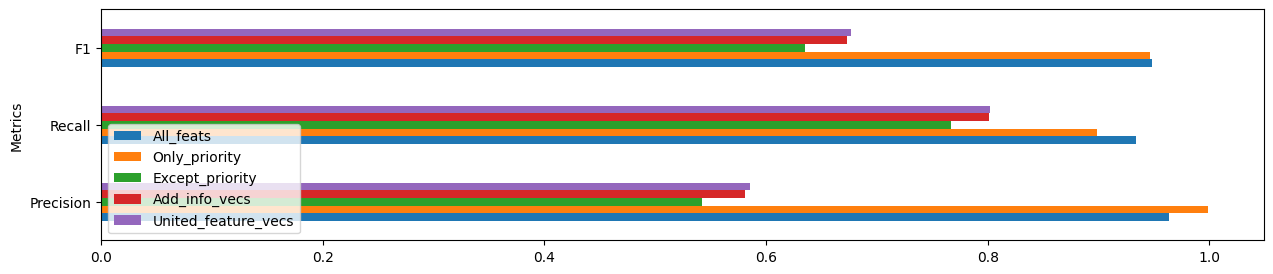

In [75]:
df_results.plot(x='Metrics', kind='barh', figsize=(15,3))
plt.legend(loc='lower left')
plt.show()

Для подбора гиперпараметров и сравнения сравнения моделей будем использовать следующую конфиурацию набора данных (как показавшую лучшие метрики на базовой модели):
- без признака `priority`, 
- признаки `one_host` и `one_net` кодируются по методу One-Hot
- все остальные признаки объединяются в одну строку и векторизуются по алгоритму TF-IDF, после чего фильтьруются по критерию Chi2 > 1.4
- набор данных преобразуется в CSR-матрицу

In [78]:
# Подготовка данных для обучения
y = df_features.label
X = df_features[['one_host','one_net']]

# Преобразовать категориальные признаки по методу One-Hot
X = X.astype('category')
X = pd.get_dummies(X, columns=X.columns)

# Добавить новые признаки, полученные при векторизации значений признака title
X = pd.concat([X, df_united_feature], axis=1)

# Преобразование набора данных в разряженную матрицу типа CSR  
X = X.astype(pd.SparseDtype('float32',0)).sparse.to_coo().tocsr()
X.shape

(6547, 956)

In [79]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Разделить набор данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)

#### Logistic Regression

Выполним подбор гиперпараметров модели

In [82]:
# params = [
#       {'solver': ['lbfgs', 'liblinear','newton-cg','newton-cholesky'],
#        'penalty': ['l1','l2'],
#        'C': [0.825, 0.85, 0.875],
#        'class_weight': ['balanced'],
#        'max_iter': range(40, 60, 1)}]

# search_cv = GridSearchCV(
#     LogisticRegression(random_state=RANDOM_STATE, n_jobs=-1), 
#     param_grid=params, scoring='recall', 
#     n_jobs=-1, cv=5, verbose=5)

# search_cv.fit(X_train,y_train)
# print('Best Estimator : {}'.format(search_cv.best_estimator_))
# print('Best Accuracy Through Grid Search : {:.3f}\n'.format(search_cv.best_score_))

Fitting 5 folds for each of 480 candidates, totalling 2400 fits
Best Estimator : LogisticRegression(C=0.85, class_weight='balanced', max_iter=47, n_jobs=-1,
                   random_state=42)
Best Accuracy Through Grid Search : 0.801



Best Estimator : LogisticRegression(C=0.85, class_weight='balanced', max_iter=47, n_jobs=-1, random_state=42)  
Best Recall Through Grid Search : 0.801

In [83]:
lgr = LogisticRegression(C=0.85, class_weight='balanced', max_iter=47, n_jobs=-1, random_state=42)

scores = cross_validate(lgr, X, y, scoring=['f1','recall','precision'], cv=skf, n_jobs=-1)
# Средние значения метрик перекрестной проверки
df_results['LGR_best'] = pd.Series([scores['test_precision'].mean(), scores['test_recall'].mean(), scores['test_f1'].mean()])
df_results

,Metrics,All_feats,Only_priority,Except_priority,Add_info_vecs,United_feature_vecs,LGR_best
0,Precision,0.963532,0.998932,0.542107,0.580843,0.585800,0.582072
1,Recall,0.933591,0.898942,0.766593,0.800774,0.801741,0.799336
2,F1,0.948224,0.946247,0.634966,0.672938,0.676646,0.673267


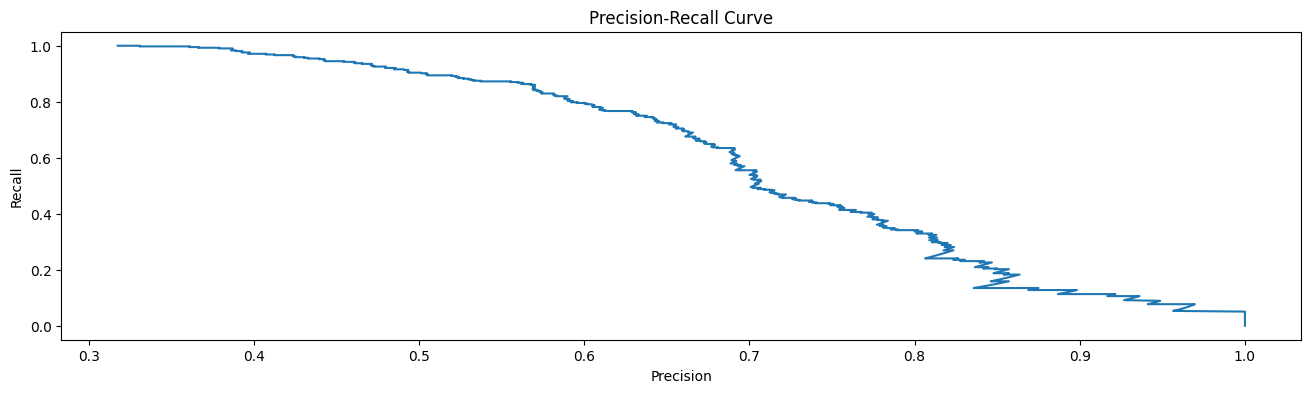

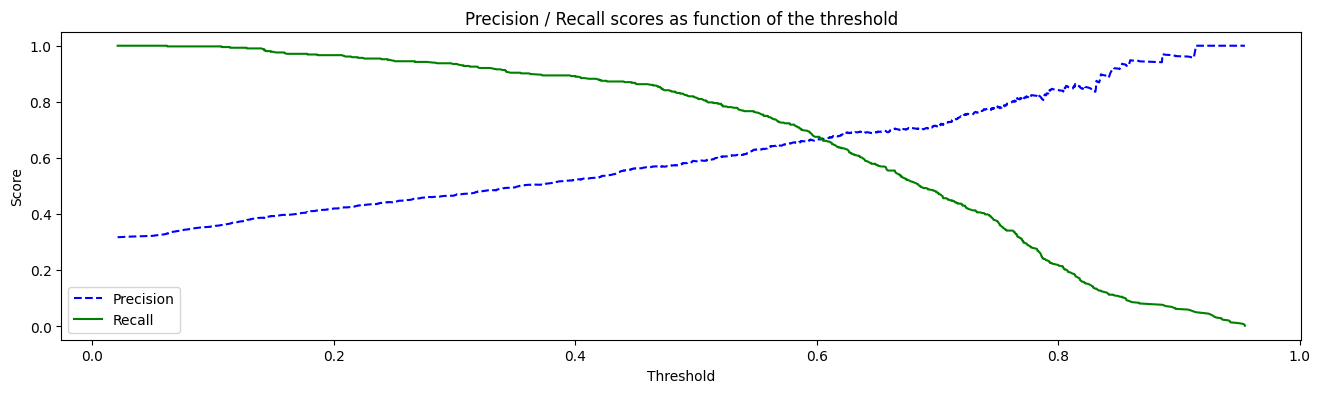

In [84]:
lgr.fit(X_train, y_train)
# Сохранить обученную модель в файл
pickle.dump(lgr, open('lgr_model', 'wb'))

y_score = lgr.predict_proba(X_test)[:,1]
lgr_precision, lgr_recall, thresholds = metrics.precision_recall_curve(y_test, y_score)

plt.figure(figsize=(16, 4))
plt.title("Precision-Recall Curve")
plt.plot(lgr_precision, lgr_recall)
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.show() 

plt.figure(figsize=(16, 4))
plt.title('Precision / Recall scores as function of the threshold')
plt.plot(thresholds, lgr_precision[:-1], "b--", label="Precision")
plt.plot(thresholds, lgr_recall[:-1], "g-", label="Recall")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.legend()
plt.show()

In [85]:
# Загрузить обученную модель из файла
# lgr = pickle.load(open('lgr_model', 'rb'))

In [102]:
LGR_THRESHOLD = 0.113
y_pred = (y_score >= LGR_THRESHOLD).astype(bool)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.20      0.33       894
           1       0.37      1.00      0.53       416

    accuracy                           0.45      1310
   macro avg       0.68      0.60      0.43      1310
weighted avg       0.79      0.45      0.39      1310



Logistic Regression


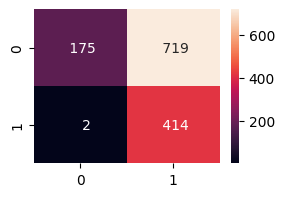

In [103]:
print('Logistic Regression')
plt.figure(figsize=(3,2))
sns.heatmap(metrics.confusion_matrix(y_test, y_pred), annot=True, fmt='4.0f');

#### Random Forest Classifier

Выполним подбор гиперпараметров модели

In [108]:
# params = [
#      {'n_estimators': range(200, 240, 5),
#       'criterion': ['entropy', 'log_loss', 'gini'],
#       'max_features': ['sqrt', 'log2', 'auto' ],
#       'class_weight': ['balanced_subsample'],
#       'max_features': ['log2','sqrt','auto'],
#       'max_depth': range(10, 16, 1)}]

# search_cv = GridSearchCV(
#     RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1), 
#     param_grid=params, scoring='recall', 
#     n_jobs=-1, cv=5, verbose=5)

# search_cv.fit(X_train,y_train)
# print('Best Estimator : {}'.format(search_cv.best_estimator_))
# print('Best Accuracy Through Grid Search : {:.3f}\n'.format(search_cv.best_score_))

Fitting 5 folds for each of 432 candidates, totalling 2160 fits
Best Estimator : RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       max_depth=10, n_estimators=235, n_jobs=-1,
                       random_state=42)
Best Accuracy Through Grid Search : 0.851



Best Estimator : RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy', max_depth=10, n_estimators=235, n_jobs=-1, random_state=42)
Best Accuracy Through Grid Search : 0.851

In [109]:
rfc = RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy', max_depth=10, n_estimators=235, n_jobs=-1, random_state=42)

scores = cross_validate(rfc, X, y, scoring=['f1','recall','precision'], cv=skf, n_jobs=-1)
# Средние значения метрик перекрестной проверки
df_results['RFC_best'] = pd.Series([scores['test_precision'].mean(), scores['test_recall'].mean(), scores['test_f1'].mean()])
df_results

,Metrics,All_feats,Only_priority,Except_priority,Add_info_vecs,United_feature_vecs,LGR_best,RFC_best
0,Precision,0.963532,0.998932,0.542107,0.580843,0.585800,0.582072,0.544709
1,Recall,0.933591,0.898942,0.766593,0.800774,0.801741,0.799336,0.835418
2,F1,0.948224,0.946247,0.634966,0.672938,0.676646,0.673267,0.659380


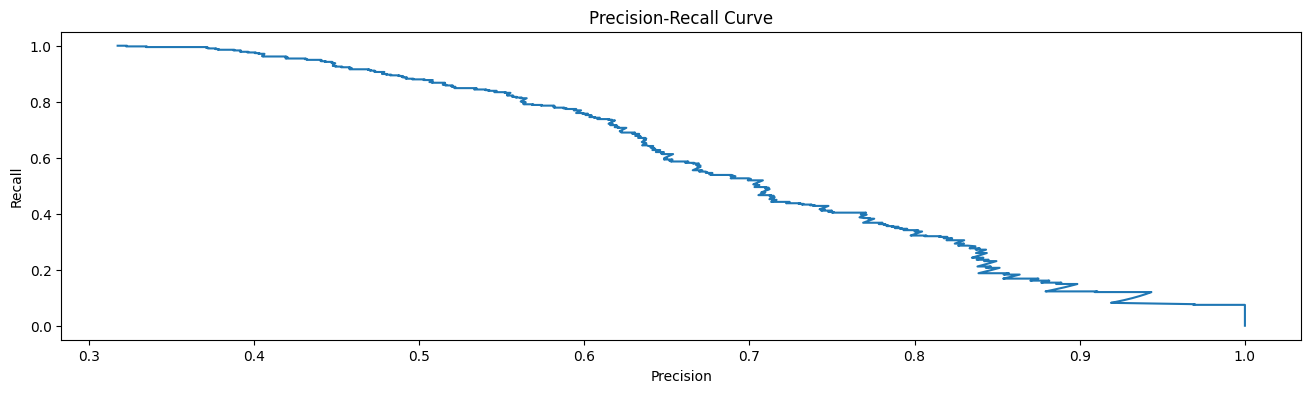

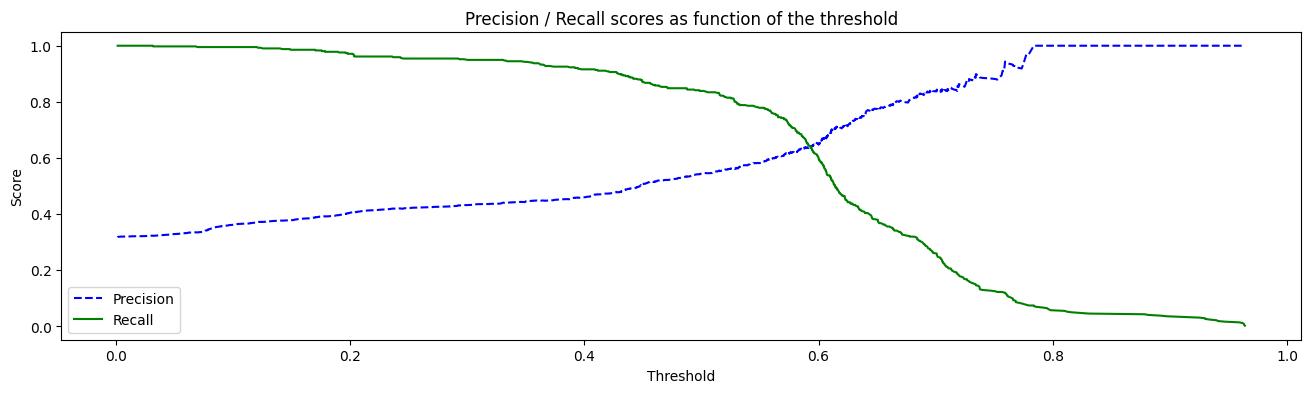

In [110]:
rfc.fit(X_train, y_train)

# Сохранить обученную модель в файл
pickle.dump(rfc, open('rfc_model', 'wb'))

y_score = rfc.predict_proba(X_test)[:,1]
rfc_precision, rfc_recall, thresholds = metrics.precision_recall_curve(y_test, y_score)

plt.figure(figsize=(16, 4))
plt.title("Precision-Recall Curve")
plt.plot(rfc_precision, rfc_recall)
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.show() 

plt.figure(figsize=(16, 4))
plt.title('Precision / Recall scores as function of the threshold')
plt.plot(thresholds, rfc_precision[:-1], "b--", label="Precision")
plt.plot(thresholds, rfc_recall[:-1], "g-", label="Recall")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.legend()
plt.show()

In [111]:
# rfc = pickle.load(open('rfc_model', 'rb'))

In [124]:
RFC_THRESHOLD = 0.120
y_pred = (y_score >= RFC_THRESHOLD).astype(bool)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.21      0.35       894
           1       0.37      1.00      0.54       416

    accuracy                           0.46      1310
   macro avg       0.68      0.60      0.45      1310
weighted avg       0.79      0.46      0.41      1310



Random Forest


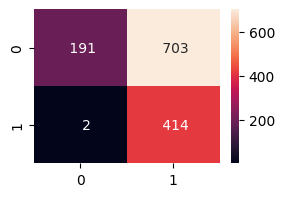

In [125]:
print('Random Forest')
plt.figure(figsize=(3,2))
sns.heatmap(metrics.confusion_matrix(y_test, y_pred), annot=True, fmt='4.0f');

#### XGBoost Classifier

Выполним подбор гиперпараметров модели

1. Подбор оптимальных значений гиперпараметров `learning_rate` и `n_estimators`

In [135]:
# param_test1 = {
#     'learning_rate':[0.325, 0.35, 0.375],
#     'n_estimators': range(200,300,5),
# }

# search_cv = GridSearchCV(
#     estimator=XGBClassifier(objective= 'binary:logistic', seed=RANDOM_STATE,
#                             learning_rate=0.35, n_estimators=265, 
#                             colsample_bytree=0.925, subsample=0.575,
#                             gamma=0.06, reg_alpha=0.05),
#     param_grid=param_test1, scoring='recall', n_jobs=-1, cv=5, verbose=5)
# search_cv.fit(X_train,y_train)

# print('Best Parameters : {}'.format(search_cv.best_params_))
# print('Best Scores through Grid Search : {:.3f}\n'.format(search_cv.best_score_))

Fitting 5 folds for each of 60 candidates, totalling 300 fits
Best Parameters : {'learning_rate': 0.35, 'n_estimators': 265}
Best Scores through Grid Search : 0.612



Best Parameters : {'learning_rate': 0.35, 'n_estimators': 265}  
Best Scores through Grid Search : 0.608

2. Подбор оптимальных значений `subsample` и `colsample_bytree`

In [129]:
# param_test2 = {
#     'colsample_bytree':[0.85, 0.875, 0.9, 0.925],
#     'subsample':[0.55, 0.575, 0.6, 0.625, 0.65],
# }

# search_cv = GridSearchCV(
#     estimator=XGBClassifier(objective= 'binary:logistic', seed=RANDOM_STATE,
#                             learning_rate=0.35, n_estimators=265),
#     param_grid=param_test2, scoring='recall', n_jobs=-1, cv=5, verbose=5)
# search_cv.fit(X_train,y_train)

# print('Best Parameters : {}'.format(search_cv.best_params_))
# print('Best Scores through Grid Search : {:.3f}\n'.format(search_cv.best_score_))

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Parameters : {'colsample_bytree': 0.925, 'subsample': 0.575}
Best Scores through Grid Search : 0.604



Best Parameters : {'colsample_bytree': 0.925, 'subsample': 0.575}  
Best Scores through Grid Search : 0.604

3. Подбор оптимальных значений `gamma` и `reg_alpha`

In [133]:
# param_test3 = {
#     'gamma':[i/100.0 for i in range(0,10)],
#     'reg_alpha':[0.001, 0.025, 0.05, 0.075, 0.1]
# }

# search_cv = GridSearchCV(
#     estimator=XGBClassifier(objective= 'binary:logistic', seed=RANDOM_STATE,
#                             learning_rate=0.35, n_estimators=265,
#                             colsample_bytree=0.925, subsample=0.575), 
#     param_grid=param_test3, scoring='recall', n_jobs=-1, cv=5, verbose=5)
# search_cv.fit(X_train,y_train)

# print('Best Parameters : {}'.format(search_cv.best_params_))
# print('Best Scores through Grid Search : {:.3f}\n'.format(search_cv.best_score_))

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Parameters : {'gamma': 0.06, 'reg_alpha': 0.05}
Best Scores through Grid Search : 0.612



Best Parameters : {'gamma': 0.06, 'reg_alpha': 0.05}  
Best Scores through Grid Search : 0.612

Обучение модели с подобранными гиперпараметрами

In [136]:
xgb = XGBClassifier(objective= 'binary:logistic', seed=RANDOM_STATE,
                    learning_rate=0.35, n_estimators=265, 
                    colsample_bytree=0.925, subsample=0.575,
                    gamma=0.06, reg_alpha=0.05)

scores = cross_validate(xgb, X, y, scoring=['f1','recall','precision'], cv=skf, n_jobs=-1)
# Средние значения метрик перекрестной проверки
df_results['XGB_best'] = pd.Series([scores['test_precision'].mean(), scores['test_recall'].mean(), scores['test_f1'].mean()])
df_results

,Metrics,All_feats,Only_priority,Except_priority,Add_info_vecs,United_feature_vecs,LGR_best,RFC_best,XGB_best
0,Precision,0.963532,0.998932,0.542107,0.580843,0.585800,0.582072,0.544709,0.627927
1,Recall,0.933591,0.898942,0.766593,0.800774,0.801741,0.799336,0.835418,0.567845
2,F1,0.948224,0.946247,0.634966,0.672938,0.676646,0.673267,0.659380,0.596037


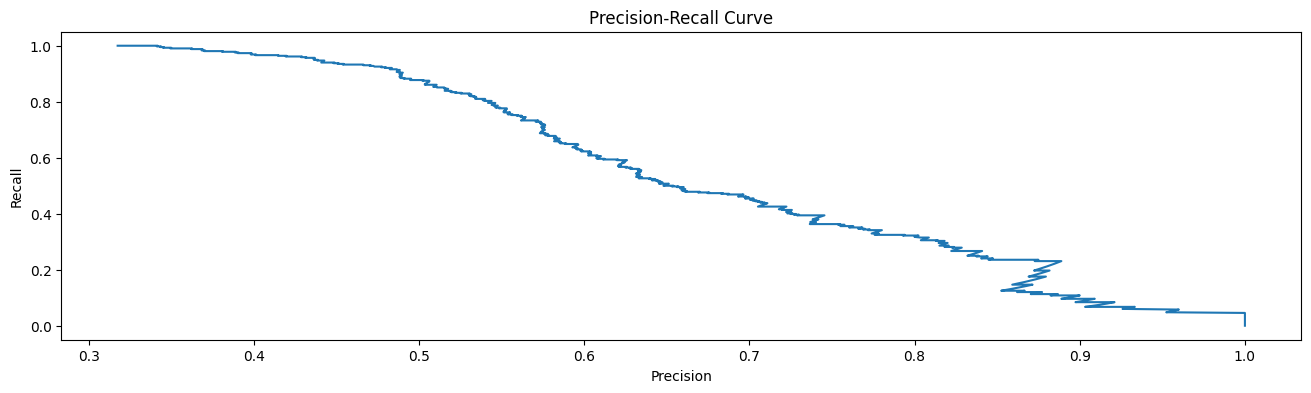

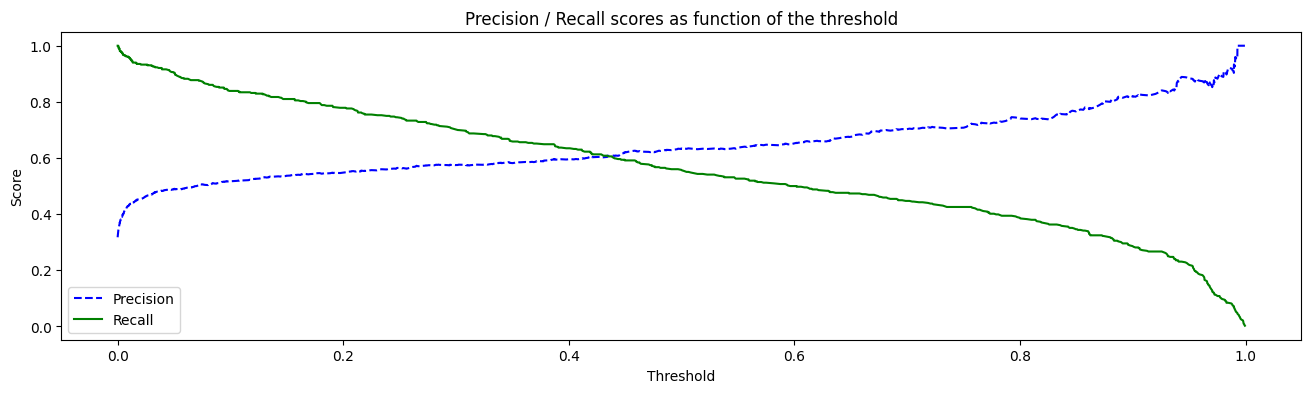

In [137]:
xgb.fit(X_train, y_train)

# Сохранить обученную модель в файл
pickle.dump(xgb, open('xgb_model', 'wb'))

y_score = xgb.predict_proba(X_test)[:,1]
xgb_precision, xgb_recall, thresholds = metrics.precision_recall_curve(y_test, y_score)

plt.figure(figsize=(16, 4))
plt.title("Precision-Recall Curve")
plt.plot(xgb_precision, xgb_recall)
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.show() 

plt.figure(figsize=(16, 4))
plt.title('Precision / Recall scores as function of the threshold')
plt.plot(thresholds, xgb_precision[:-1], "b--", label="Precision")
plt.plot(thresholds, xgb_recall[:-1], "g-", label="Recall")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.legend()
plt.show()

In [138]:
# xgb = pickle.load(open('xgb_model', 'rb'))

In [146]:
RFC_THRESHOLD = 0.0007
y_pred = (y_score >= RFC_THRESHOLD).astype(bool)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.12      0.21       894
           1       0.34      1.00      0.51       416

    accuracy                           0.40      1310
   macro avg       0.66      0.56      0.36      1310
weighted avg       0.78      0.40      0.30      1310



XGBoost


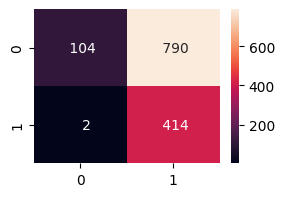

In [147]:
print('XGBoost')
plt.figure(figsize=(3,2))
sns.heatmap(metrics.confusion_matrix(y_test, y_pred), annot=True, fmt='4.0f');

#### Сравним метрики всех обученных моделей

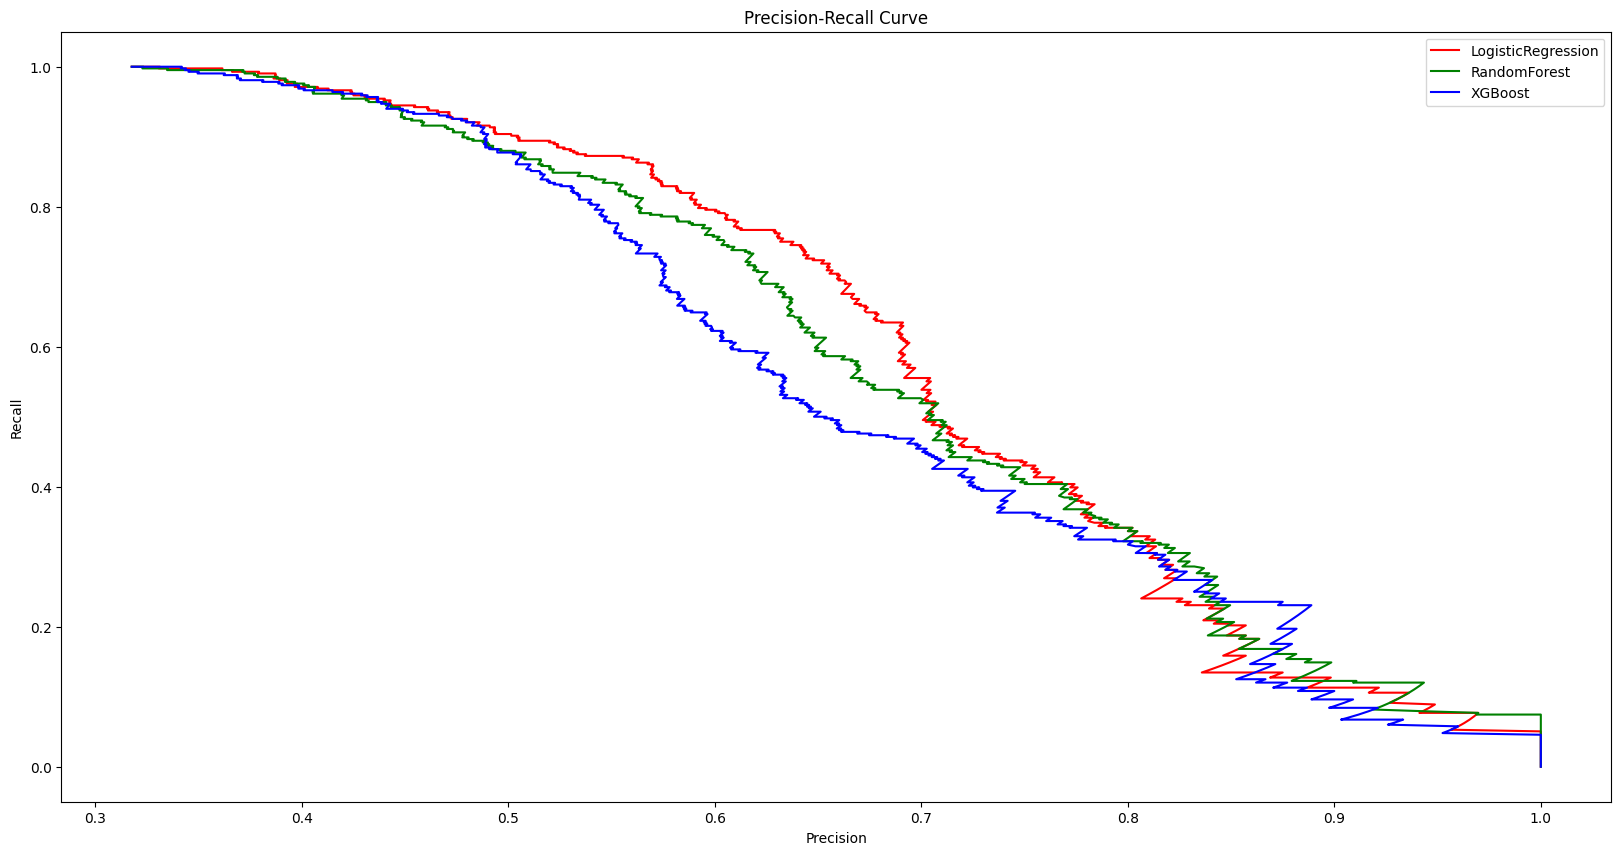

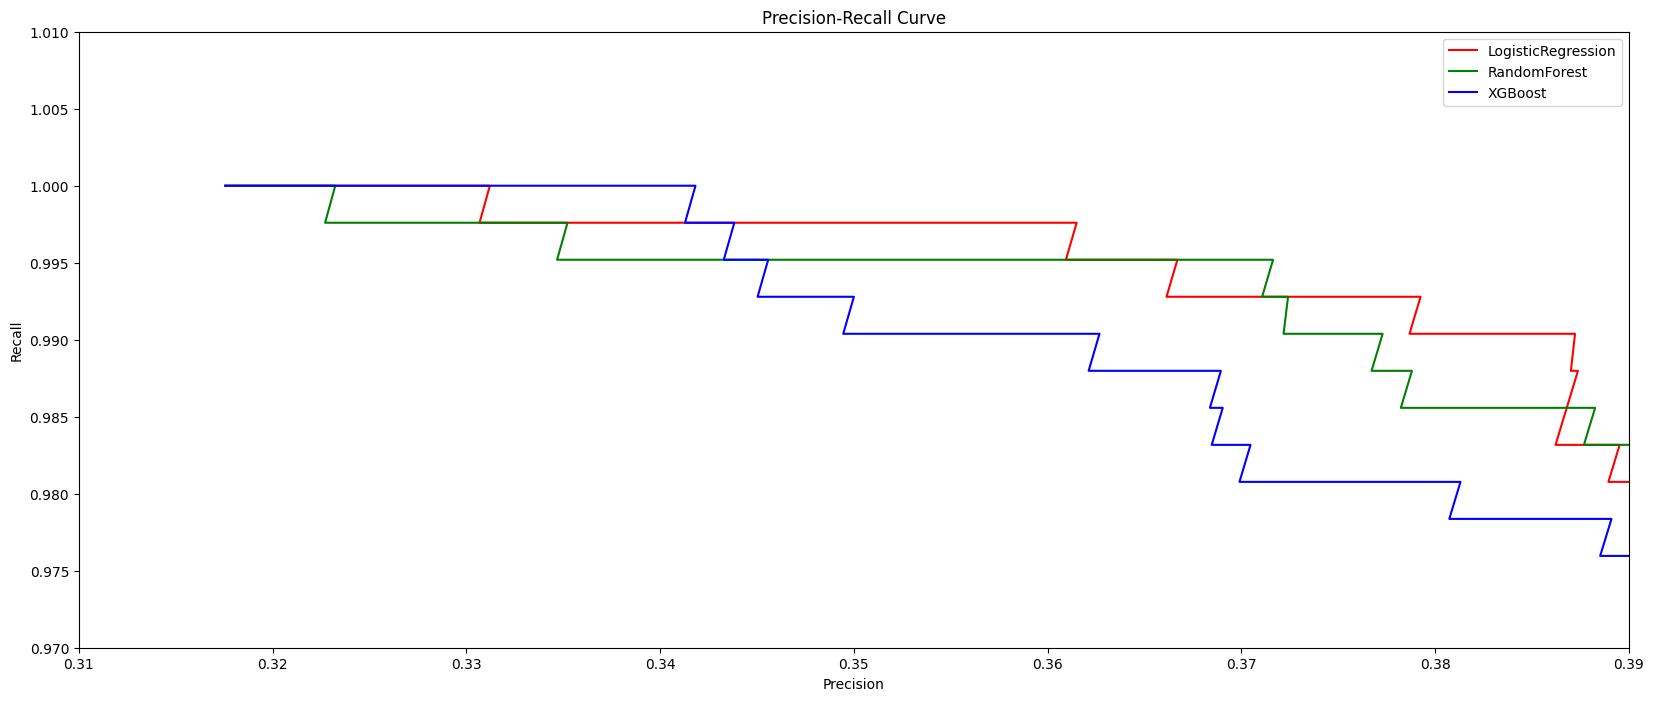

In [149]:
plt.figure(figsize=(20, 10))
plt.title("Precision-Recall Curve")
plt.plot(lgr_precision,lgr_recall, "r-", label='LogisticRegression')
plt.plot(rfc_precision,rfc_recall, "g-", label='RandomForest')
plt.plot(xgb_precision,xgb_recall, "b-", label='XGBoost')
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.legend()
plt.show()

plt.figure(figsize=(20, 8))
plt.title("Precision-Recall Curve")
plt.plot(lgr_precision,lgr_recall, "r-", label='LogisticRegression')
plt.plot(rfc_precision,rfc_recall, "g-", label='RandomForest')
plt.plot(xgb_precision,xgb_recall, "b-", label='XGBoost')
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.ylim([0.97, 1.01])
plt.xlim([0.31, 0.39])
plt.legend()
plt.show()

#### Выводы:
На полученном наборе данных удалось достигнуть минимальных желаемых значений метрик (см. постановку задачи).  
Для значения метрики `Recall` = `1.0`, соответствующее значение `Precision` для рассмотренных моделей составило:
- для LogisticRegression        precision = 0.37
- для RandomForestClassifier    precision = `0.37`
- для XGBoostClassifier         precision = 0.34

Mодель `LogisticRegression` показала лучшую скорость обучения и метрики близкие к RandomForest , но при этом не имеет потенциала для дальнейшего улучшения метрик.  
Mодель `RandomForestClasifier` показала лучшие значения метрик но низкую скорость обучения, однако еще имеется некоторый потенциал для улучшения метрик модели подстройкой гиперпараметров.   
Mодель `XGBoostClassifier` показала худшие метрики и самое долгое время обучения. Однако большое количество настраиваемых гиперпараметров оставляют возможности по дальнейшей настройке.

    Итого:  
- Минимальные желаемые метрики достигнуты
- Имеются возможности по улучшению метрик с учетом того, что исходный набор данных имеет сильные искажения в следствии работы с ним аналитиков приложения и дополнительной перекодировки значений признаков для удовлетворения требованиями NDA.

### P.S.

Обучим лучшую модель (RandomForestClasifier) на данных с учетом "волшебного" признака `priority`

In [170]:
# Подготовка данных для обучения
y = df_features.label
X = df_features[['priority','one_host','one_net']]

# Преобразовать категориальные признаки по методу One-Hot
X = X.astype('category')
X = pd.get_dummies(X, columns=X.columns)

# Добавить новые признаки, полученные при векторизации значений признака title
X = pd.concat([X, df_united_feature], axis=1)

# Преобразование набора данных в разряженную матрицу типа CSR  
X = X.astype(pd.SparseDtype('float32',0)).sparse.to_coo().tocsr()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)

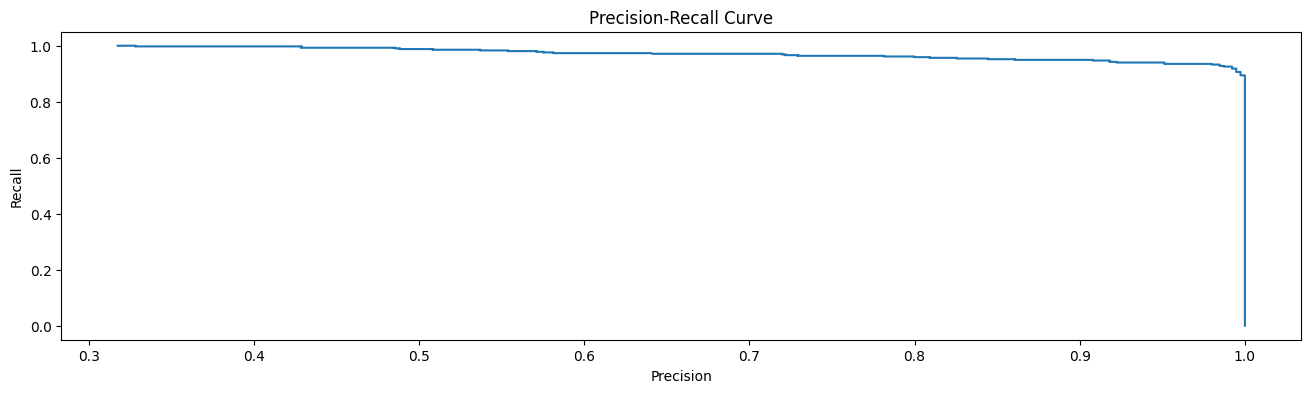

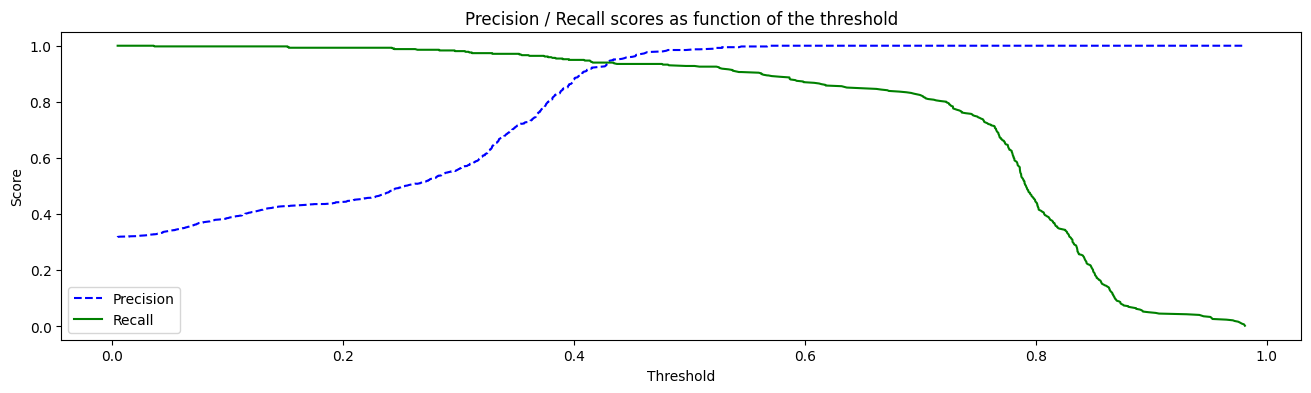

In [151]:
rfc.fit(X_train, y_train)

y_score = rfc.predict_proba(X_test)[:,1]
rfc_precision, rfc_recall, thresholds = metrics.precision_recall_curve(y_test, y_score)

plt.figure(figsize=(16, 4))
plt.title("Precision-Recall Curve")
plt.plot(rfc_precision, rfc_recall)
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.show() 

plt.figure(figsize=(16, 4))
plt.title('Precision / Recall scores as function of the threshold')
plt.plot(thresholds, rfc_precision[:-1], "b--", label="Precision")
plt.plot(thresholds, rfc_recall[:-1], "g-", label="Recall")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.legend()
plt.show()

In [168]:
LGR_THRESHOLD = 0.152
y_pred = (y_score >= LGR_THRESHOLD).astype(bool)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.38      0.55       894
           1       0.43      1.00      0.60       416

    accuracy                           0.58      1310
   macro avg       0.71      0.69      0.58      1310
weighted avg       0.81      0.58      0.57      1310



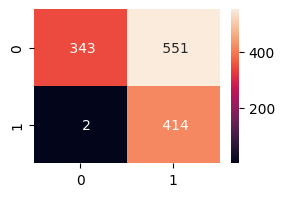

In [169]:
plt.figure(figsize=(3,2))
sns.heatmap(metrics.confusion_matrix(y_test, y_pred), annot=True, fmt='4.0f');

Итого,  
Для значения метрики `Recall`= 100% максимальный показатель `Precision` в данном исследовании = 43%  
при условии использования в наборе данных читерского признака `priority`

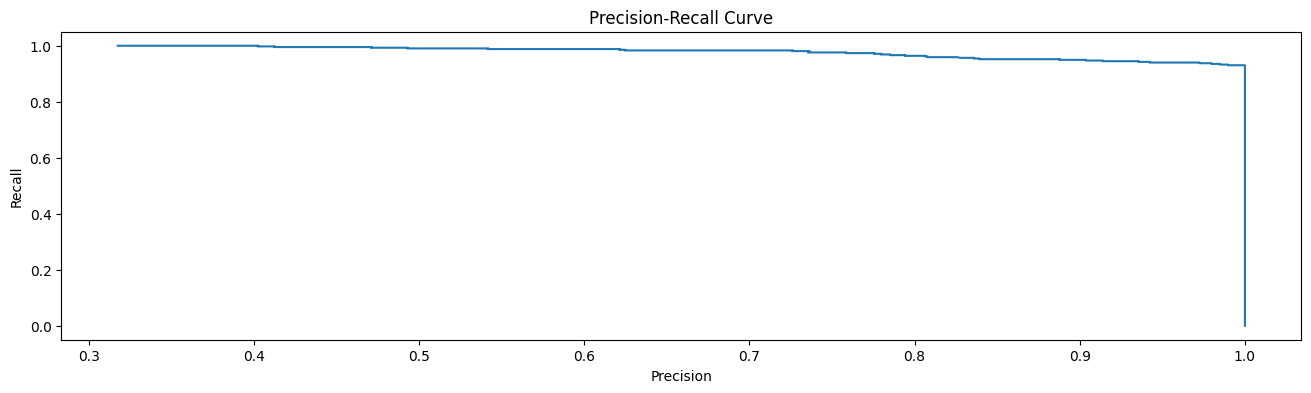

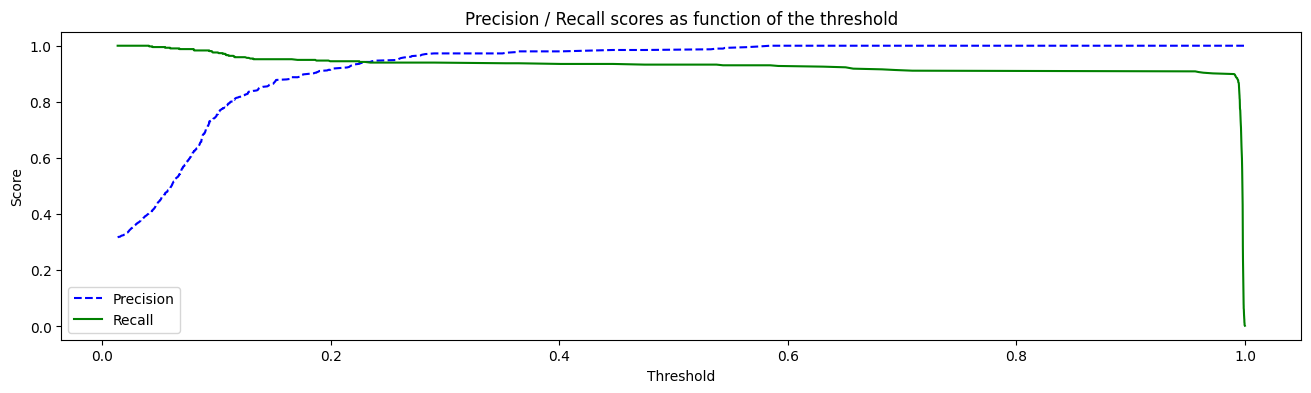

In [171]:
lgr.fit(X_train, y_train)
# Сохранить обученную модель в файл
pickle.dump(lgr, open('lgr_model', 'wb'))

y_score = lgr.predict_proba(X_test)[:,1]
lgr_precision, lgr_recall, thresholds = metrics.precision_recall_curve(y_test, y_score)

plt.figure(figsize=(16, 4))
plt.title("Precision-Recall Curve")
plt.plot(lgr_precision, lgr_recall)
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.show() 

plt.figure(figsize=(16, 4))
plt.title('Precision / Recall scores as function of the threshold')
plt.plot(thresholds, lgr_precision[:-1], "b--", label="Precision")
plt.plot(thresholds, lgr_recall[:-1], "g-", label="Recall")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.legend()
plt.show()

In [187]:
LGR_THRESHOLD = 0.055
y_pred = (y_score >= LGR_THRESHOLD).astype(bool)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.48      0.65       894
           1       0.47      1.00      0.64       416

    accuracy                           0.64      1310
   macro avg       0.73      0.74      0.64      1310
weighted avg       0.83      0.64      0.64      1310



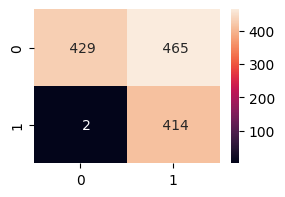

In [188]:
plt.figure(figsize=(3,2))
sns.heatmap(metrics.confusion_matrix(y_test, y_pred), annot=True, fmt='4.0f');